In [2]:
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import defaultdict, Counter
from matplotlib.lines import Line2D
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.contingency_tables import StratifiedTable

In [3]:
with open("accession_translator.json", "r") as s:
    accession_translator = json.load(s)

In [4]:
sns.set_theme(style="whitegrid")

In [5]:
def parse_hmmscan_table(path, dataset):
    results = defaultdict(list)
    with open(path, 'r') as stream:
        for line in stream:
            if line.startswith("#"):
                continue
            parts = line.split()
            results["target"].append(parts[0])
            results["pfam"].append(parts[1].split('.')[0])
            transcript = parts[2]
            if dataset in ["augustus", "braker3"]:
                gene = transcript[:-3]
            elif dataset in ["helixer", "reference"]:
                gene = transcript[:-2]
            elif "GeneML" in dataset:
                gene = transcript.replace("_mRNA","")
            else:
                raise ValueError(f"Invalid argument for dataset: {dataset}")
            results["gene"].append(gene)
    return pd.DataFrame.from_dict(results)

In [6]:
paths = glob.glob("/home/lisvad/mnt/nisin/geneml/outputs/*/pfam*")
dfs = []
for path in paths:
    file_name = path.split('/')[-1]
    accession = file_name.replace("pfam_","").replace(".tsv","")
    dataset = path.split('/')[-2]
    pfam_df = parse_hmmscan_table(path, dataset)
    pfam_df["accession"] = accession
    pfam_df["dataset"] = dataset
    dfs.append(pfam_df)
all_stats = pd.concat(dfs)

In [7]:
datasets = {
    "augustus": "AUGUSTUS",
#    "braker3_noprotdb": "BRAKER3 (no orthoDB)",
    "braker3": "BRAKER3",
    "helixer": "Helixer",
    "GeneML800_c657g_ncbi_for_benchmarking_ep10": "geneML",
    "reference": "Reference",
}

In [8]:
all_stats["dataset"] = pd.Categorical(all_stats["dataset"], categories=datasets.keys(), ordered=True)
all_stats["dataset"] = all_stats["dataset"].map(datasets)
all_stats["species"] = all_stats["accession"].map(accession_translator)
all_stats["species"] = pd.Categorical(all_stats["species"], categories=accession_translator.values(), ordered=True)
all_stats

,target,pfam,gene,accession,dataset,species
0,Sel1,PF08238,g1,GCA_964035595.1,AUGUSTUS,Somion occarium
1,UCH,PF00443,g4,GCA_964035595.1,AUGUSTUS,Somion occarium
2,UCH_1,PF13423,g4,GCA_964035595.1,AUGUSTUS,Somion occarium
3,ubiquitin,PF00240,g5,GCA_964035595.1,AUGUSTUS,Somion occarium
4,UBA,PF00627,g5,GCA_964035595.1,AUGUSTUS,Somion occarium
...,...,...,...,...,...,...
16863,RTC4,PF14474,rna-XM_023605033,GCF_033473495.1,Reference,Cercospora beticola
16864,BTB,PF00651,rna-XM_023605034,GCF_033473495.1,Reference,Cercospora beticola
16865,Zn_clus,PF00172,rna-XM_023605037,GCF_033473495.1,Reference,Cercospora beticola
16866,Chromo,PF00385,rna-XM_023605040,GCF_033473495.1,Reference,Cercospora beticola


In [9]:
hit_counts = all_stats.groupby(["accession","dataset"])["gene"].nunique().reset_index(name="pfam_hits")
hit_counts["species"] = hit_counts["accession"].map(accession_translator)
hit_counts["species"] = pd.Categorical(hit_counts["species"], categories=accession_translator.values(), ordered=True)

/tmp/ipykernel_35090/1619089206.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hit_counts = all_stats.groupby(["accession","dataset"])["gene"].nunique().reset_index(name="pfam_hits")


In [10]:
gene_counts = pd.read_csv("/home/lisvad/mnt/nisin/geneml/benchmarking_stats.tsv", sep="\t")
gene_counts = gene_counts.drop(["genes","braker3_noprotdb"], axis=1)
gene_counts = gene_counts.rename(columns={"protein_coding_genes":"reference","genome":"accession","geneml":"GeneML800_c657g_ncbi_for_benchmarking_ep10"})
gene_counts = gene_counts.melt(id_vars=["accession","genome_size"], var_name="dataset", value_name="genes")
gene_counts["dataset"] = pd.Categorical(gene_counts["dataset"], categories=datasets.keys(), ordered=True)
gene_counts["dataset"] = gene_counts["dataset"].map(datasets)
gene_counts.head()

,accession,genome_size,dataset,genes
0,GCA_964035595.1,30870404,Reference,11245
1,GCF_000143535.2,42630066,Reference,11698
2,GCF_000146045.2,12071326,Reference,6002
3,GCF_000240135.3,36458046,Reference,13312
4,GCF_000835755.1,17799622,Reference,6646


In [11]:
hit_counts = hit_counts.merge(gene_counts, on=["dataset","accession"])

In [12]:
tool_palette = {
    "AUGUSTUS" : "#5A749F",
    "BRAKER3" : "#B53535",
    "Helixer" : "#622870",
    "geneML" : "#FFAA00",
    "Reference" : "#000000",
}

In [13]:
hit_counts["pfam_percentage"] = hit_counts["pfam_hits"]/hit_counts["genes"]*100
hit_counts["normalised_hits"] = hit_counts["pfam_hits"]/hit_counts["genome_size"]*1e6

In [14]:
ref = hit_counts[hit_counts["dataset"]=="Reference"]
ref_counts = dict(zip(ref["accession"], ref["pfam_hits"]))
hit_counts["relative_to_ref"] = hit_counts["pfam_hits"]/hit_counts["accession"].map(ref_counts)
hit_counts.groupby(["dataset"])["relative_to_ref"].agg(['mean','std'])

/tmp/ipykernel_35090/91378897.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hit_counts.groupby(["dataset"])["relative_to_ref"].agg(['mean','std'])


,mean,std
dataset,,
AUGUSTUS,0.765498,0.231738
BRAKER3,1.121764,0.209437
Helixer,1.120989,0.212616
geneML,1.074951,0.172048
Reference,1.000000,0.000000


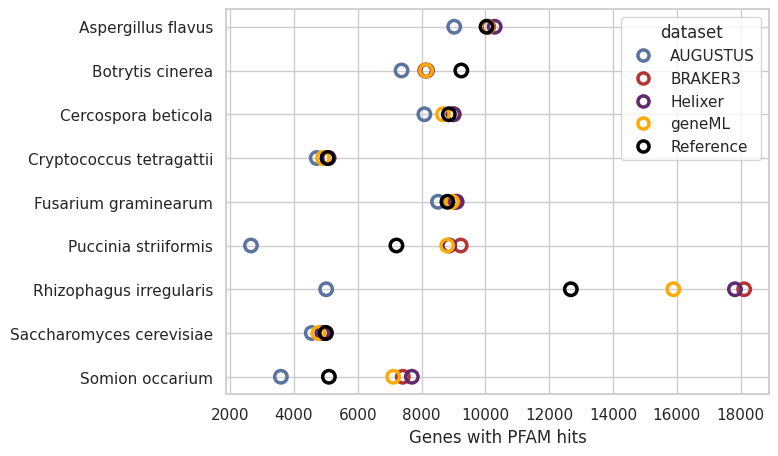

In [15]:
hue_order=hit_counts["dataset"].cat.categories.tolist()

species_order=hit_counts["species"].cat.categories.tolist()[::-1]
species_to_y = {species: i for i, species in enumerate(species_order)}
hit_counts['y_pos'] = hit_counts['species'].map(species_to_y)


fig, ax = plt.subplots(figsize=(7, 5))

# Plot points in the same order as pointplot: species first, hue second
for species in species_order:
    for dataset in hue_order:
        subset = hit_counts[(hit_counts['species'] == species) &
                            (hit_counts['dataset'] == dataset)]
        if not subset.empty:
            ax.scatter(
                subset['pfam_hits'],
                subset['y_pos'],
                s=80,
                facecolors='none',           # hollow
                edgecolors=tool_palette[dataset],  # colored border
                linewidth=2.5,
            )

# Fix y-axis
ax.set_yticks(list(species_to_y.values()))
ax.set_yticklabels(species_order)

# Create legend with hollow markers
handles = [
    Line2D([0], [0], marker='o', color='w', label=dataset,
           markerfacecolor='none', markeredgecolor=color,
           markersize=8, markeredgewidth=2.5)
    for dataset, color in tool_palette.items()
]

ax.legend(handles=handles, title='dataset')

plt.xlabel("Genes with PFAM hits")
plt.show()

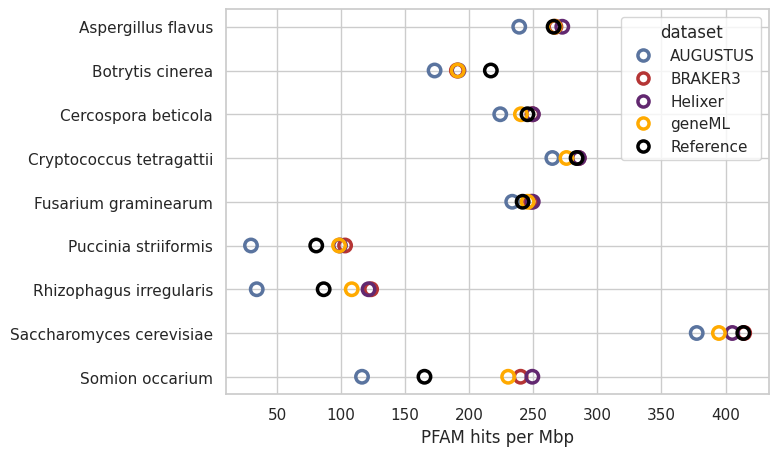

In [16]:
hue_order=hit_counts["dataset"].cat.categories.tolist()

species_order=hit_counts["species"].cat.categories.tolist()[::-1]
species_to_y = {species: i for i, species in enumerate(species_order)}
hit_counts['y_pos'] = hit_counts['species'].map(species_to_y)


fig, ax = plt.subplots(figsize=(7, 5))

# Plot points in the same order as pointplot: species first, hue second
for species in species_order:
    for dataset in hue_order:
        subset = hit_counts[(hit_counts['species'] == species) &
                            (hit_counts['dataset'] == dataset)]
        if not subset.empty:
            ax.scatter(
                subset['normalised_hits'],
                subset['y_pos'],
                s=80,
                facecolors='none',           # hollow
                edgecolors=tool_palette[dataset],  # colored border
                linewidth=2.5,
            )

# Fix y-axis
ax.set_yticks(list(species_to_y.values()))
ax.set_yticklabels(species_order)

# Create legend with hollow markers
handles = [
    Line2D([0], [0], marker='o', color='w', label=dataset,
           markerfacecolor='none', markeredgecolor=color,
           markersize=8, markeredgewidth=2.5)
    for dataset, color in tool_palette.items()
]

ax.legend(handles=handles, title='dataset')

plt.xlabel("PFAM hits per Mbp")
plt.show()

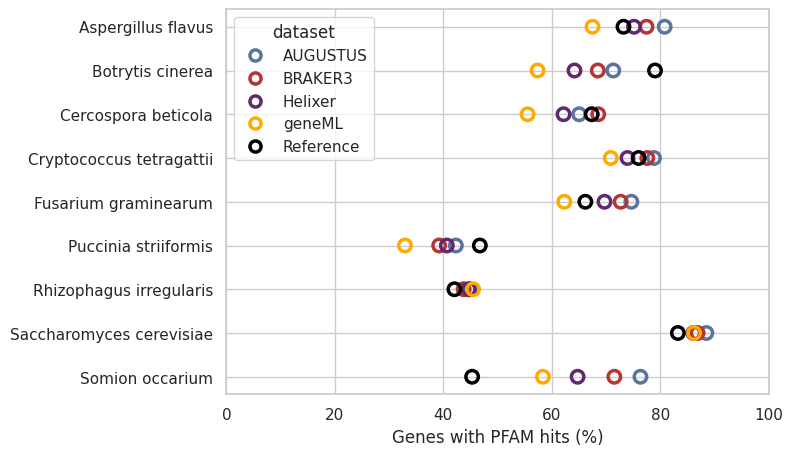

In [17]:
hue_order=hit_counts["dataset"].cat.categories.tolist()

species_order=hit_counts["species"].cat.categories.tolist()[::-1]
species_to_y = {species: i for i, species in enumerate(species_order)}
hit_counts['y_pos'] = hit_counts['species'].map(species_to_y)


fig, ax = plt.subplots(figsize=(7, 5))

# Plot points in the same order as pointplot: species first, hue second
for species in species_order:
    for dataset in hue_order:
        subset = hit_counts[(hit_counts['species'] == species) &
                            (hit_counts['dataset'] == dataset)]
        if not subset.empty:
            ax.scatter(
                subset['pfam_percentage'],
                subset['y_pos'],
                s=80,
                facecolors='none',           # hollow
                edgecolors=tool_palette[dataset],  # colored border
                linewidth=2.5,
            )

# Fix y-axis
ax.set_yticks(list(species_to_y.values()))
ax.set_yticklabels(species_order)

# Create legend with hollow markers
handles = [
    Line2D([0], [0], marker='o', color='w', label=dataset,
           markerfacecolor='none', markeredgecolor=color,
           markersize=8, markeredgewidth=2.5)
    for dataset, color in tool_palette.items()
]

ax.legend(handles=handles, title='dataset')

plt.xlabel("Genes with PFAM hits (%)")
plt.xlim(0,100)
plt.show()

In [18]:
all_stats_unique = all_stats.drop_duplicates()

In [19]:
# Function to compute overlap with multiplicity
def overlap_ratio(list1, list2):
    c1 = Counter(list1)
    c2 = Counter(list2)
    # Count minimum occurrences for each element
    intersection_count = sum((c1 & c2).values())
    return intersection_count / len(list1)  # divide by length of first list

# Function to compute overlap matrix for a single group1
def overlap_matrix(sub_df, group_column, value_column):
    groups = sub_df[group_column].unique()
    matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)

    # Compute pairwise overlaps
    for g1 in groups:
        list1 = sub_df.loc[sub_df[group_column]==g1, value_column].tolist()
        for g2 in groups:
            list2 = sub_df.loc[sub_df[group_column]==g2, value_column].tolist()
            matrix.loc[g1, g2] = overlap_ratio(list1, list2)
    return matrix

# Compute and store results for all group1
dfs = []
for g1_val, sub_df in all_stats_unique.groupby("species"):
    mat = overlap_matrix(sub_df, "dataset", "pfam")
    mat = mat.reset_index().melt(id_vars='index', var_name='dataset_2', value_name='overlap')
    mat["species"] = g1_val
    mat.rename(columns={'index': 'dataset_1'}, inplace=True)
    dfs.append(mat)

plot_df = pd.concat(dfs, ignore_index=True)
plot_df

/tmp/ipykernel_35090/3649400552.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g1_val, sub_df in all_stats_unique.groupby("species"):


,dataset_1,dataset_2,overlap,species
0,AUGUSTUS,AUGUSTUS,1.000000,Aspergillus flavus
1,geneML,AUGUSTUS,0.948787,Aspergillus flavus
2,BRAKER3,AUGUSTUS,0.936587,Aspergillus flavus
3,Helixer,AUGUSTUS,0.940988,Aspergillus flavus
4,Reference,AUGUSTUS,0.947837,Aspergillus flavus
...,...,...,...,...
220,AUGUSTUS,Reference,0.995375,Somion occarium
221,geneML,Reference,0.962002,Somion occarium
222,BRAKER3,Reference,0.989108,Somion occarium
223,Helixer,Reference,0.972314,Somion occarium


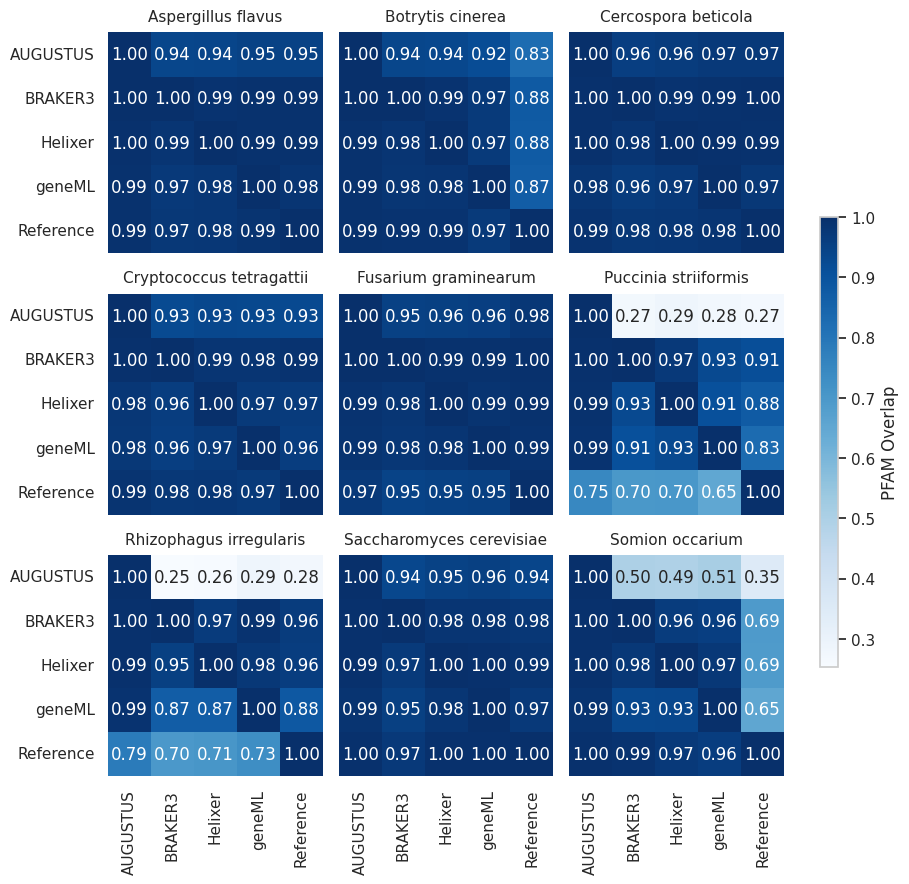

In [20]:
# Compute global color limits for consistent color scaling
vmin, vmax = plot_df['overlap'].min(), plot_df['overlap'].max()

# Define plotting function for each facet
def heatmap(data, **kwargs):
    data_pivot = data.pivot(index='dataset_2',columns='dataset_1',values='overlap')
    # Reindex rows and columns to ensure consistent order
    data_pivot = data_pivot.reindex(index=datasets.values(), columns=datasets.values())
    ax = sns.heatmap(
        data_pivot, annot=True, fmt='.2f', cmap='Blues',
        vmin=vmin, vmax=vmax, cbar=False
    )
    ax.set_xlabel('')
    ax.set_ylabel('')

g = sns.FacetGrid(plot_df, col='species', col_wrap=3)
g.map_dataframe(heatmap)

g.set_titles(col_template="{col_name}", size=11, pad=8)
g.fig.subplots_adjust(right=0.88)  # leave space on the right side

# Add one shared colorbar
cbar_ax = g.fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
g.fig.colorbar(sm, cax=cbar_ax, label='PFAM Overlap')

plt.show()

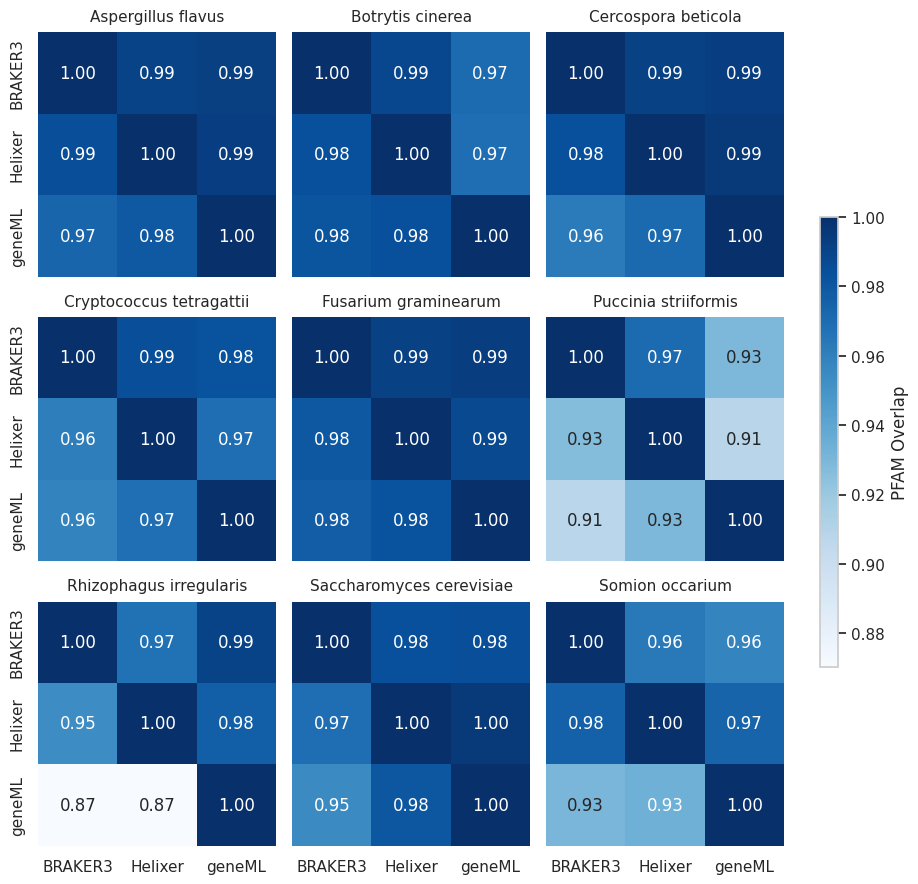

In [21]:
plot_df_less = plot_df[(~plot_df["dataset_1"].isin(["AUGUSTUS","Reference"])) & (~plot_df["dataset_2"].isin(["AUGUSTUS","Reference"]))]
# Compute global color limits for consistent color scaling
vmin, vmax = plot_df_less['overlap'].min(), plot_df_less['overlap'].max()

# Define plotting function for each facet
def heatmap(data, **kwargs):
    data_pivot = data.pivot(index='dataset_2',columns='dataset_1',values='overlap')
    # Reindex rows and columns to ensure consistent order
    order = ["BRAKER3","Helixer","geneML"]
    data_pivot = data_pivot.reindex(index=order, columns=order)
    ax = sns.heatmap(
        data_pivot, annot=True, fmt='.2f', cmap='Blues',
        vmin=vmin, vmax=vmax, cbar=False
    )
    ax.set_xlabel('')
    ax.set_ylabel('')

g = sns.FacetGrid(plot_df_less, col='species', col_wrap=3)
g.map_dataframe(heatmap)

g.set_titles(col_template="{col_name}", size=11, pad=8)
g.fig.subplots_adjust(right=0.88)  # leave space on the right side

# Add one shared colorbar
cbar_ax = g.fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
g.fig.colorbar(sm, cax=cbar_ax, label='PFAM Overlap')

plt.show()

In [22]:
def get_stats(count_table, name):
    dataset1, dataset2 = count_table["dataset"].unique()

    # Pivot table for chi-square
    pivot_table = count_table.pivot_table(
        index=name,
        columns=['dataset', "accession"],
        values='count',
        fill_value=0
    )
    # Continuity correction to avoid zeros
    count_table_corrected = pivot_table + 0.5

    results_list = []
    for item in count_table_corrected.index:
        table_2d = count_table_corrected.loc[item].unstack(level=0).T.values
        chi2, p, dof, expected = chi2_contingency(table_2d)

        results_list.append({
            name: item,
            'chi2': chi2,
            'p_value': p,
        })

    results_df = pd.DataFrame(results_list)

    # Adjust p-values
    results_df['p_adj'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    results_df['significant_adj'] = results_df['p_adj'] < 0.05

    # Add total counts per dataset
    counts_total = count_table.groupby([name,'dataset'])['count'].sum().unstack(fill_value=0)
    for ds in [dataset1, dataset2]:
        results_df[ds + '_count'] = results_df[name].map(counts_total[ds])

    # Fold-change
    pseudo = 1e-6
    results_df['fold_change'] = (results_df[dataset1 + '_count'] + pseudo) / (results_df[dataset2 + '_count'] + pseudo)

    # Flag values both significant and meaningfully enriched
    fc_threshold = 1.5
    results_df['significant_and_enriched'] = results_df['significant_adj'] & ((results_df['fold_change'] >= fc_threshold) | (results_df['fold_change'] <= 1/fc_threshold))

    results_df.sort_values('p_adj', inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    return results_df

In [23]:
pfam_counts = all_stats_unique.groupby(['pfam', 'dataset', "accession"]).size().reset_index(name='count')
pfam_counts_geneml_ref = pfam_counts[pfam_counts["dataset"].isin(["geneML","Reference"])]

pfam_stats = get_stats(pfam_counts_geneml_ref, "pfam")

/tmp/ipykernel_35090/1649949593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pfam_counts = all_stats_unique.groupby(['pfam', 'dataset', "accession"]).size().reset_index(name='count')
/tmp/ipykernel_35090/2735571745.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = count_table.pivot_table(
/tmp/ipykernel_35090/2735571745.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_total = count_table.groupby([name,'dataset'])['

In [24]:
target_mapping = dict(zip(all_stats["pfam"], all_stats["target"]))
pfam_stats["target"] = pfam_stats["pfam"].map(target_mapping)

In [25]:
pfam_stats[pfam_stats["significant_and_enriched"]][:20]

,pfam,chi2,p_value,p_adj,significant_adj,geneML_count,Reference_count,fold_change,significant_and_enriched,target
0,PF00665,259.456056,1.701629e-51,9.951126e-48,True,664,57,1.164912e+01,True,rve
1,PF07727,179.454405,1.340269e-34,3.918946e-31,True,517,54,9.574074e+00,True,RVT_2
2,PF00078,176.544718,5.469731e-34,1.066233e-30,True,1167,22,5.304545e+01,True,RVT_1
3,PF00075,167.407544,4.504573e-32,6.585685e-29,True,421,19,2.215789e+01,True,RNase_H
4,PF17919,160.698129,1.142745e-30,1.336555e-27,True,875,15,5.833333e+01,True,RT_RNaseH_2
5,PF17921,159.997407,1.601355e-30,1.560787e-27,True,789,26,3.034615e+01,True,Integrase_H2C2
6,PF17917,159.311571,2.227866e-30,1.861223e-27,True,874,15,5.826666e+01,True,RT_RNaseH
8,PF13650,71.949595,2.008534e-12,1.305101e-09,True,491,84,5.845238e+00,True,Asp_protease_2
9,PF05699,68.393694,1.025483e-11,5.997024e-09,True,780,47,1.659574e+01,True,Dimer_Tnp_hAT
10,PF13683,55.975606,2.851869e-09,1.516157e-06,True,135,0,1.350000e+08,True,rve_3


In [26]:
mapping_file = "../../data/pfam2go.txt"
mapping_df = pd.read_csv(mapping_file, sep="\t", skiprows=6, header=None, names=["raw"])
mapping_df["pfam"] = mapping_df["raw"].str.extract(r"Pfam:(PF\d+)")
go_id = mapping_df["raw"].str.extract(r"(GO:\d+)")
mapping_df["GO_desc"] = mapping_df["raw"].str.extract(r"> (.*?) ; GO")
mapping_df["GO_desc"] = mapping_df["GO_desc"].str.replace("GO:","")
pfam_to_go = mapping_df[["pfam", "GO_ID", "GO_desc"]].drop_duplicates()

KeyError: "['GO_ID'] not in index"

In [ ]:
pfam_counts_geneml_ref = pfam_counts_geneml_ref.merge(pfam_to_go)
go_counts_geneml_ref = pfam_counts_geneml_ref.groupby(['GO_ID','dataset',"accession"], observed=True, sort=False)['count'].sum().reset_index()

In [ ]:
go_stats = get_stats(go_counts_geneml_ref, "GO_ID")

/tmp/ipykernel_24672/2735571745.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = count_table.pivot_table(
/tmp/ipykernel_24672/2735571745.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_total = count_table.groupby([name,'dataset'])['count'].sum().unstack(fill_value=0)


In [ ]:
go_mapping = dict(zip(pfam_to_go["GO_ID"], pfam_to_go["GO_desc"]))
go_stats["GO_desc"] = go_stats["GO_ID"].map(go_mapping)

In [ ]:
go_stats[go_stats["significant_and_enriched"]][:20]

,GO_ID,chi2,p_value,p_adj,significant_adj,geneML_count,Reference_count,fold_change,significant_and_enriched,GO_desc
0,GO:0015074,361.175916,3.722167e-73,5.307810e-70,True,921,58,15.879310,True,DNA integration
1,GO:0003676,330.196083,1.519922e-66,1.083704e-63,True,2025,1183,1.711750,True,nucleic acid binding
2,GO:0046983,256.661788,6.662463e-51,3.166891e-48,True,971,252,3.853175,True,protein dimerization activity
3,GO:0004523,180.452472,8.271976e-35,2.948959e-32,True,431,29,14.862068,True,RNA-DNA hybrid ribonuclease activity
17,GO:0003678,44.295116,5.003762e-07,3.964091e-05,True,196,73,2.684931,True,DNA helicase activity
18,GO:0004190,40.016330,3.181358e-06,2.291312e-04,True,182,28,6.500000,True,aspartic-type endopeptidase activity
20,GO:0000723,37.826356,8.105207e-06,5.503822e-04,True,175,46,3.804348,True,telomere maintenance
22,GO:0006313,28.529302,3.833955e-04,2.377052e-02,True,210,9,23.333331,True,DNA transposition


In [29]:
pfam_counts = all_stats_unique.groupby(['pfam', 'dataset']).size().reset_index(name='count')
pfam_counts_wide = pfam_counts.pivot_table(index="dataset", columns="pfam", values="count", fill_value=0)

/tmp/ipykernel_35090/2712766386.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pfam_counts = all_stats_unique.groupby(['pfam', 'dataset']).size().reset_index(name='count')
/tmp/ipykernel_35090/2712766386.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pfam_counts_wide = pfam_counts.pivot_table(index="dataset", columns="pfam", values="count", fill_value=0)


/tmp/ipykernel_35090/2609157307.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings_df.PC1[i], loadings_df.PC2[i],
/tmp/ipykernel_35090/2609157307.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings_df.PC1[i]*1.1, loadings_df.PC2[i]*1.1, loadings_df.index[i], color='r')


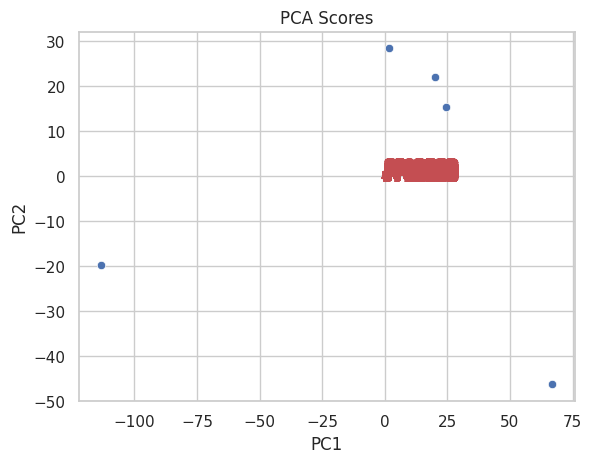

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pfam_counts_wide)

# PCA
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(scaled_data)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Convert to DataFrame for plotting
scores_df = pd.DataFrame(pca_scores, columns=['PC1', 'PC2'])
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=pfam_counts_wide.columns)

# Plot PCA scores
sns.scatterplot(x='PC1', y='PC2', data=scores_df)
plt.title('PCA Scores')

# Plot loadings as arrows
for i in range(loadings_df.shape[0]):
    plt.arrow(0, 0, loadings_df.PC1[i], loadings_df.PC2[i],
              color='r', alpha=0.5, head_width=0.05)
    plt.text(loadings_df.PC1[i]*1.1, loadings_df.PC2[i]*1.1, loadings_df.index[i], color='r')

In [33]:
scores_df

,PC1,PC2
0,-113.124692,-19.682265
1,24.364013,15.461028
2,20.104815,22.100994
3,1.754997,28.419421
4,66.900867,-46.299179


In [34]:
pfam_counts_wide

pfam,PF00001,PF00002,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,...,PF20515,PF20516,PF20518,PF20520,PF20521,PF20526,PF20566,PF20571,PF20584,PF20618
dataset,,,,,,,,,,,,,,,,,,,,,
AUGUSTUS,6.0,7.0,438.0,396.0,35.0,149.0,84.0,31.0,118.0,54.0,...,2.0,3.0,4.0,5.0,8.0,1.0,1.0,1.0,0.0,1.0
BRAKER3,17.0,9.0,556.0,440.0,37.0,189.0,104.0,43.0,172.0,86.0,...,84.0,2.0,4.0,6.0,7.0,1.0,1.0,1.0,1.0,1.0
Helixer,16.0,9.0,549.0,444.0,37.0,185.0,104.0,41.0,167.0,90.0,...,91.0,4.0,4.0,5.0,9.0,1.0,1.0,1.0,1.0,1.0
geneML,10.0,9.0,533.0,438.0,38.0,173.0,102.0,39.0,162.0,83.0,...,92.0,3.0,4.0,6.0,8.0,1.0,1.0,1.0,1.0,1.0
Reference,16.0,8.0,587.0,482.0,40.0,206.0,110.0,46.0,174.0,104.0,...,61.0,3.0,4.0,6.0,9.0,1.0,1.0,1.0,1.0,2.0
